In [29]:
# if jupyterlab:
%matplotlib widget
# if jupyter notebook:
# %matplotlib notebook

import numpy as np 
from recoMRD import recoMRD
from recoMRD import utils
from bart import bart

In [30]:
filename = './../example_data/meas_MID00019_FID04966_localizer2D_iPAT2.mrd'
mrd = recoMRD(filename)

mrd.img = mrd.kspace_to_image(mrd.kspace['image_scan'])
img_sos = mrd.remove_oversampling(mrd.img)
img_sos = mrd.coil_combination(img_sos, method='sos')

MRD file has more than one group. The last group will be imported.
Number of reference scans: 72
Number of image     scans: 336
k-space size in protocol: 448 x 224 x 1
image   size in protocol: 224 x 224 x 1
Acceleration factor: 2 x 1
Reference scan type: integrated
Existing scans: acs, noise, image_scan.
Fully sampled array size=[16, 448, 224, 1, 3, 1, 1, 1, 1, 1, 1]


Filling acs       , size=[16, 448, 24, 1, 3, 1, 1, 1, 1, 1, 1]: 100%|███████████████████████████████████████████| 72/72 [00:00<00:00, 10060.29it/s]
Filling noise     , size=[16, 448, 1, 1, 1, 1, 1, 1, 1, 1, 1]: 100%|███████████████████████████████████████████████| 1/1 [00:00<00:00, 2006.84it/s]
Filling image_scan, size=[16, 448, 112, 1, 3, 1, 1, 1, 1, 1, 1]: 100%|█████████████████████████████████████████| 336/336 [00:00<00:00, 8736.18it/s]


Reorder slice... Done.


Fourier transform: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 115.51it/s]


Remove oversampling... Done.


/kyb/agks/aaghaeifar/.local/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:502: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


(224, 224, 3)


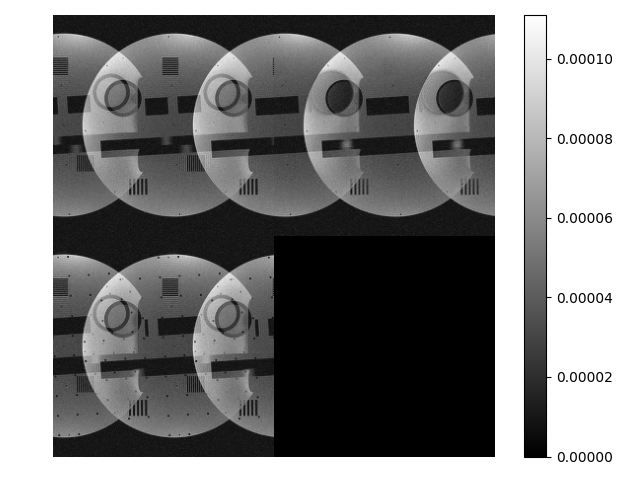

In [31]:
print(img_sos.squeeze().shape)
temp = img_sos.squeeze()
temp = utils.plot_mosaic(temp, cmap='gray')

(448, 224, 3)
Acceleration Factor: R=2.00


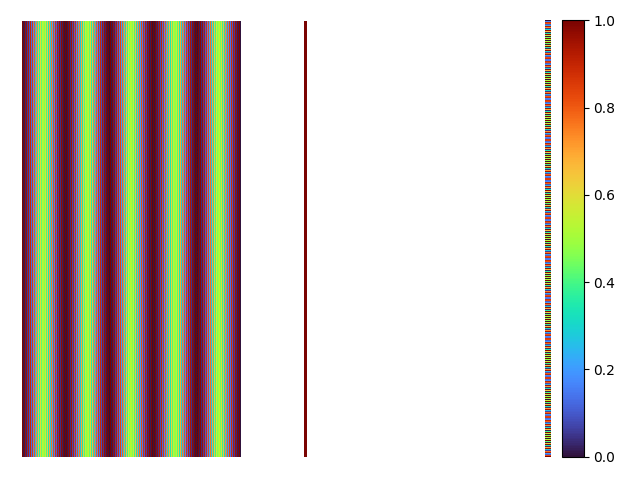

In [32]:
# show sampling pattern
temp = mrd.kspace['image_scan'].squeeze()[0,...] # take the first coil
mask = bart.bart(1, 'pattern', temp).real > 0
print(mask.shape)
shp = [x // 2 for x in mask.shape]
R = np.prod(np.shape(mask)) / np.sum(mask) # acceleration factor
utils.plot3D(mask, clim=[0, 1])
print('Acceleration Factor: R={:.2f}'.format(R))

(16, 448, 224, 3)
(448, 3584)


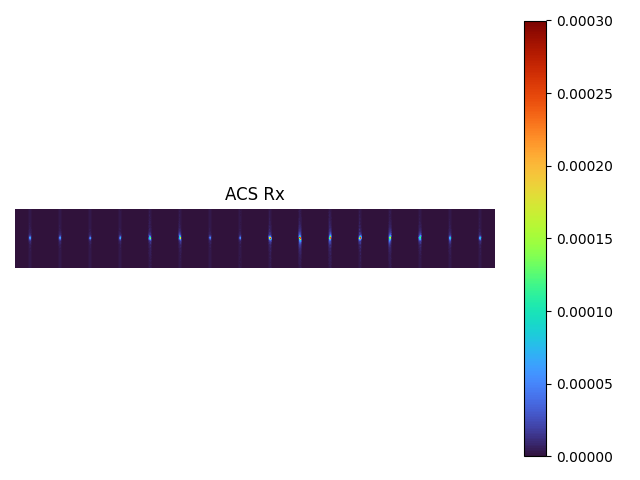

In [33]:
# show some Rx channels from reference scan
temp = mrd.kspace['acs'].squeeze()
print(temp.shape)
temp = np.abs(np.moveaxis(temp[:,:,:,1],0,-1))
temp = utils.plot_mosaic(temp, grid_shape = [1, temp.shape[2]], clim=[0, 3e-4], title='ACS Rx')
print(temp.shape)

Fourier transform: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 138.50it/s]


Remove oversampling... Done.
(1, 224, 224, 1, 3, 1, 1, 1, 1, 1, 1)
(224, 224, 3)


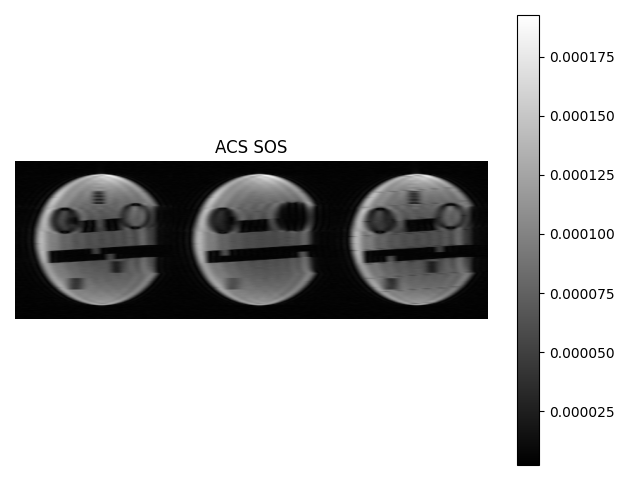

In [34]:
# sum of square of reference scan
acs_img = mrd.kspace_to_image(mrd.kspace['acs'])
acs_img = mrd.remove_oversampling(acs_img)
acs_img = mrd.coil_combination(acs_img, method='sos')

temp = acs_img.squeeze()
print(acs_img.shape)
print(temp.shape)
temp = utils.plot_mosaic(temp, grid_shape = [1, temp.shape[2]], cmap='gray', title='ACS SOS')


In [35]:
%%time
# calculate coil sensitivity, using espirit method
coils_sensitivity = mrd.calc_coil_sensitivity(mrd.kspace['acs'], method='espirit')
coils_sensitivity = mrd.remove_oversampling(coils_sensitivity)


Done.
Done.
Done.
Remove oversampling... Done.
CPU times: user 49 ms, sys: 49.5 ms, total: 98.6 ms
Wall time: 2.47 s


In [36]:
%%time
# first remove oversampling and calculate coil sensitivity, using espirit method
acs_img = mrd.kspace_to_image(mrd.kspace['acs'])
acs_img = mrd.remove_oversampling(acs_img)
acs_img = mrd.image_to_kspace(acs_img)
coils_sensitivity_os_removed1 = mrd.calc_coil_sensitivity(acs_img, method='espirit')
print(coils_sensitivity_os_removed1.shape)

Fourier transform: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 102.56it/s]

Remove oversampling... 

Done.


Fourier transform: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 212.77it/s]


Done.
Done.
Done.
(16, 224, 224, 1, 3)
CPU times: user 270 ms, sys: 41.1 ms, total: 311 ms
Wall time: 2.2 s


In [37]:
%%time
# first remove oversampling ink-space and calculate coil sensitivity, using espirit method
acs_img = mrd.kspace['acs']
acs_img = mrd.remove_oversampling(acs_img, is_kspace=True)
coils_sensitivity_os_removed2 = mrd.calc_coil_sensitivity(acs_img, method='espirit')
print(coils_sensitivity_os_removed2.shape)

Remove oversampling... Done.
Done.
Done.
Done.
(16, 224, 224, 1, 3)
CPU times: user 42.5 ms, sys: 23.2 ms, total: 65.8 ms
Wall time: 1.93 s


In [38]:
%%time
# use caldir method to get coil sensitivity 
coils_sensitivity_caldir = mrd.calc_coil_sensitivity(mrd.kspace['acs'], method='caldir')
coils_sensitivity_caldir = mrd.remove_oversampling(coils_sensitivity_caldir)
print(coils_sensitivity_caldir.shape)

Calibration region 224x24x1
Done.
Calibration region 224x24x1
Done.
Calibration region 224x24x1
Done.
Remove oversampling... Done.
(16, 224, 224, 1, 3)
CPU times: user 54.5 ms, sys: 55.7 ms, total: 110 ms
Wall time: 1.74 s


In [39]:
%%time
# use caldir method + removed oversampling to get coil sensitivity 
coils_sensitivity_caldir_os_removed2 = mrd.calc_coil_sensitivity(acs_img, method='caldir')
print(coils_sensitivity_caldir_os_removed2.shape)

Calibration region 112x24x1
Done.
Calibration region 112x24x1
Done.
Calibration region 112x24x1
Done.
(16, 224, 224, 1, 3)
CPU times: user 41.5 ms, sys: 27 ms, total: 68.5 ms
Wall time: 828 ms


In [40]:
%%time
coils_sensitivity_adaptive_os_removed = mrd.calc_coil_sensitivity(acs_img, method='walsh')
print(coils_sensitivity_adaptive_os_removed.shape)

Fourier transform: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 295.17it/s]


(16, 224, 224, 1, 3)
CPU times: user 6.35 s, sys: 35.1 ms, total: 6.39 s
Wall time: 433 ms


(96, 224, 224)
(224, 224, 96)


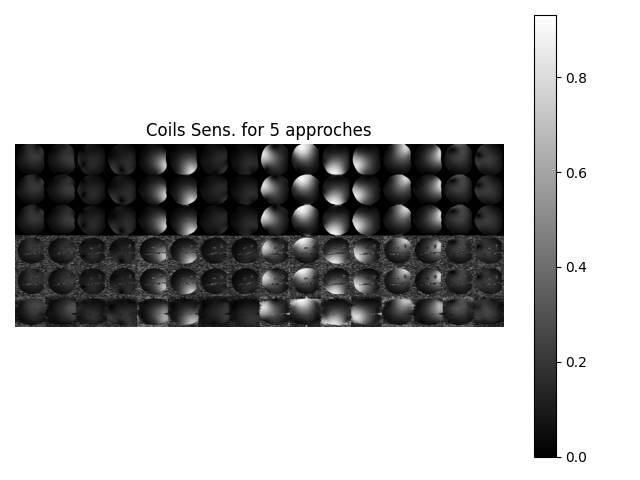

In [41]:
temp = np.concatenate((coils_sensitivity, coils_sensitivity_os_removed1, coils_sensitivity_os_removed2, coils_sensitivity_caldir, coils_sensitivity_caldir_os_removed2, coils_sensitivity_adaptive_os_removed), axis = 0)
temp = temp.squeeze()[...,1]
print(temp.shape)
temp = np.abs(np.moveaxis(temp,0,-1))
print(temp.shape)
temp = utils.plot_mosaic(temp, grid_shape = [6, temp.shape[2]/6], cmap='gray', title='Coils Sens. for 5 approches')


Remove oversampling... Done.
(16, 224, 224, 1, 3, 1, 1, 1, 1, 1, 1)
Size: 50176 Samples: 25088 Acc: 2.00
l2 regularization: 0.000100
Regularization terms: 1, Supporting variables: 0
conjugate gradients
Total Time: 0.607956
Size: 50176 Samples: 25088 Acc: 2.00
l2 regularization: 0.000100
Regularization terms: 1, Supporting variables: 0
conjugate gradients
Total Time: 0.593723
Size: 50176 Samples: 25088 Acc: 2.00
l2 regularization: 0.000100
Regularization terms: 1, Supporting variables: 0
conjugate gradients
Total Time: 0.566199
Size: 50176 Samples: 25088 Acc: 2.00
l2 regularization: 0.000100
Regularization terms: 1, Supporting variables: 0
conjugate gradients
Total Time: 0.591149
Size: 50176 Samples: 25088 Acc: 2.00
l2 regularization: 0.000100
Regularization terms: 1, Supporting variables: 0
conjugate gradients
Total Time: 0.564576
Size: 50176 Samples: 25088 Acc: 2.00
l2 regularization: 0.000100
Regularization terms: 1, Supporting variables: 0
conjugate gradients
Total Time: 0.562782
Si

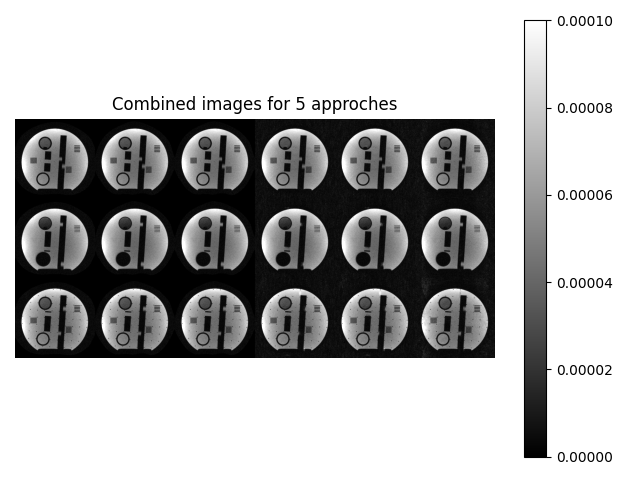

In [42]:
img = mrd.remove_oversampling(mrd.kspace['image_scan'], is_kspace=True)
print(img.shape)
volume_comb1 = mrd.coil_combination(img, method='bart', coil_sens=coils_sensitivity)
volume_comb2 = mrd.coil_combination(img, method='bart', coil_sens=coils_sensitivity_os_removed1)
volume_comb3 = mrd.coil_combination(img, method='bart', coil_sens=coils_sensitivity_os_removed2)
volume_comb4 = mrd.coil_combination(img, method='bart', coil_sens=coils_sensitivity_caldir)
volume_comb5 = mrd.coil_combination(img, method='bart', coil_sens=coils_sensitivity_caldir_os_removed2)
volume_comb6 = mrd.coil_combination(img, method='bart', coil_sens=coils_sensitivity_adaptive_os_removed)
print(volume_comb1.shape)
temp = np.concatenate((volume_comb1, volume_comb2, volume_comb3, volume_comb4, volume_comb5, volume_comb6), axis = 4).squeeze()
temp = np.abs(temp)
print(temp.shape)
temp = utils.plot_mosaic(temp, grid_shape = [6, temp.shape[2]//6], cmap='gray', clim = [0, 1e-4], transpose = True, title='Combined images for 5 approches')
